### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



### Import data

In [2]:
base_path = "../../workflow/pypsa-earth/"
df_n = pypsa.Network(base_path + "/results/US_2021/networks/elec_s_10_ec_lcopt_Co2L-24H.nc")
df_eia = pd.read_csv("../data/generation_eia.csv",index_col="Unnamed: 0")
df_eia

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Applications/anaconda3/envs/pypsa-earth/li

,Period,Coal,Natural Gas,Other Gas,Nuclear,Hydro,Solar,Renewable Sources Excluding Hydroelectric and Solar,PHS,Other,...,Petroleum,Wind,Solar PV,Solar Thermal,Wood and Wood-Derived Fuels,Landfill Gas,Biogenic Municipal Solid Waste,Other Waste Biomass,Geothermal,Total Renewable Generation at Utility Scale Facilities
0,2014,1581.710,1126.635,12.022,797.166,259.367,17.691,261.522,-6.174,13.393,...,30.231,181.655,15.250,2.441,42.340,11.220,7.228,3.202,15.877,538.579
1,2015,1352.398,1334.668,13.117,797.178,249.080,24.893,270.268,-5.091,13.955,...,28.249,190.719,21.666,3.227,41.929,11.291,7.211,3.201,15.918,544.241
2,2016,1239.149,1379.271,12.807,805.694,267.812,36.054,305.579,-6.686,13.689,...,24.205,226.993,32.670,3.384,40.947,11.218,7.265,3.331,15.826,609.445
3,2017,1205.835,1297.703,12.469,804.950,300.333,53.287,332.963,-6.495,13.008,...,21.390,254.303,50.018,3.269,41.124,11.543,6.951,3.115,15.927,686.583
4,2018,1149.487,1471.843,13.463,807.084,292.524,63.825,350.467,-5.905,12.973,...,25.226,272.667,60.234,3.592,40.936,11.036,7.136,2.724,15.967,706.816
5,2019,964.957,1588.533,12.591,809.409,287.874,71.937,368.862,-5.261,13.331,...,18.341,295.882,68.719,3.218,38.543,10.468,6.093,2.402,15.473,728.673
6,2020,773.393,1626.790,11.818,789.879,285.274,89.199,408.539,-5.321,12.855,...,17.341,337.938,86.066,3.133,36.219,10.212,6.080,2.201,15.890,783.012
7,2021,897.999,1579.190,11.397,779.645,251.585,115.258,448.424,-5.112,12.140,...,19.174,378.197,112.335,2.924,36.463,9.421,6.101,2.267,15.975,815.267
8,2022,831.512,1687.067,11.722,771.537,254.789,143.797,502.231,-6.028,11.114,...,22.931,434.297,140.798,2.999,35.464,8.535,5.776,2.073,16.087,900.817
9,2023,675.264,1802.062,11.451,775.347,239.855,164.502,489.161,-5.897,9.955,...,16.472,425.235,161.651,2.850,31.439,8.285,5.587,2.153,16.462,893.517


In [3]:
time_resolution = 24 #in Hours

In [4]:
# check whether renewables have been extended or not
df_n.generators.query('carrier == "solar"').p_nom_extendable

Generator
US0 0 solar    False
US0 1 solar    False
US0 2 solar    False
US0 3 solar    False
US0 4 solar    False
US0 5 solar    False
US0 6 solar    False
US0 7 solar    False
US0 8 solar    False
US0 9 solar    False
US1 0 solar    False
US2 0 solar    False
Name: p_nom_extendable, dtype: bool

In [5]:
df_n.statistics().round(1)

Capacity Factor  Capital Expenditure  \
            carrier                                                      
Generator   Biomass                           1.0         2.504541e+09   
            Coal                              0.9         4.951451e+10   
            Combined-Cycle Gas                0.2         2.372181e+10   
            Csp                               NaN         0.000000e+00   
            Geothermal                        1.0         1.161880e+09   
            Nuclear                           1.0         4.602384e+10   
            Offshore Wind (AC)                NaN         0.000000e+00   
            Offshore Wind (DC)                NaN         0.000000e+00   
            Oil                               0.0         5.043723e+09   
            Onshore Wind                      0.3         2.351957e+10   
            Open-Cycle Gas                    0.0         1.816447e+10   
            Solar                             0.2         7.250205e+09   
Line        AC                                0.3         1.512802e+10   
Link        B2B                               0.7         0.000000e+00   
            Csp                               inf         0.000000e+00   
            DC                                0.9         1.141763e+09   
            H2 electrolysis                   inf         0.000000e+00   
            H2 fuel cell                      0.9         0.000000e+00   
            battery charger                   NaN         0.000000e+00   
            battery discharger                inf         0.000000e+00   
Load        -                                 NaN                  NaN   
StorageUnit Pumped Hydro Storage              0.0         3.532078e+09   
            Reservoir & Dam                   0.4         0.000000e+00   
Store       Battery Storage                   NaN         0.000000e+00   
            Csp                               inf         0.000000e+00   
            Hydrogen Storage                 -0.3        -0.000000e+00   

                                  Curtailment      Dispatch  \
            carrier                                           
Generator   Biomass                       0.0  5.955398e+07   
            Coal                          0.0  1.571657e+09   
            Combined-Cycle Gas            0.0  6.972807e+08   
            Csp                           0.0  0.000000e+00   
            Geothermal                    0.0  3.473515e+07   
            Nuclear                       0.0  8.710506e+08   
            Offshore Wind (AC)            0.0  0.000000e+00   
            Offshore Wind (DC)            0.0  0.000000e+00   
            Oil                           0.0  2.127227e+05   
            Onshore Wind                  1.6  3.272330e+08   
            Open-Cycle Gas                0.0  1.885014e+07   
            Solar                         0.5  1.002768e+08   
Line        AC                            NaN  1.908747e+08   
Link        B2B                           NaN -8.400584e+06   
            Csp                           NaN -0.000000e+00   
            DC                            NaN  7.729010e+07   
            H2 electrolysis               NaN -0.000000e+00   
            H2 fuel cell                  NaN  0.000000e+00   
            battery charger               NaN  0.000000e+00   
            battery discharger            NaN  0.000000e+00   
Load        -                             NaN -3.988187e+09   
StorageUnit Pumped Hydro Storage          0.0  0.000000e+00   
            Reservoir & Dam               0.0  3.073368e+08   
Store       Battery Storage               NaN  0.000000e+00   
            Csp                           NaN -0.000000e+00   
            Hydrogen Storage              NaN -0.000000e+00   

                                  Installed Capacity  Market Value  \
            carrier                                                  
Generator   Biomass                           6798.4    

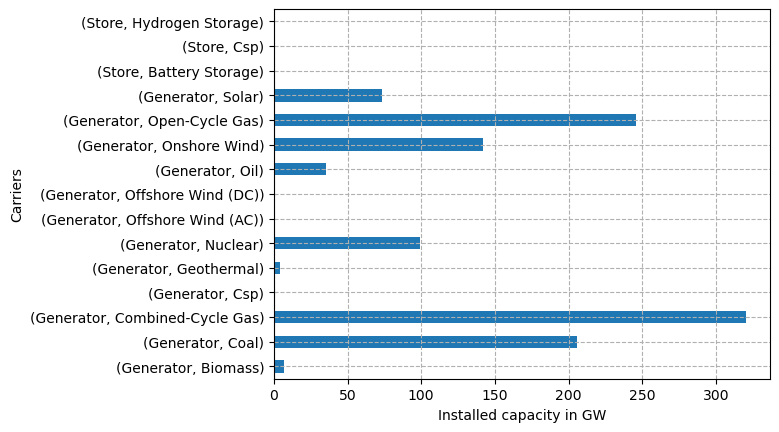

In [6]:
stats = df_n.statistics().round(1)["Installed Capacity"] / 1e3
installed_cap = stats.loc[["Generator","Store"]]
# installed_cap = installed_cap.drop(('Generator','load'))
installed_cap.plot(kind='barh')
plt.xlabel("Installed capacity in GW")
plt.ylabel("Carriers")
plt.grid(linestyle='--')

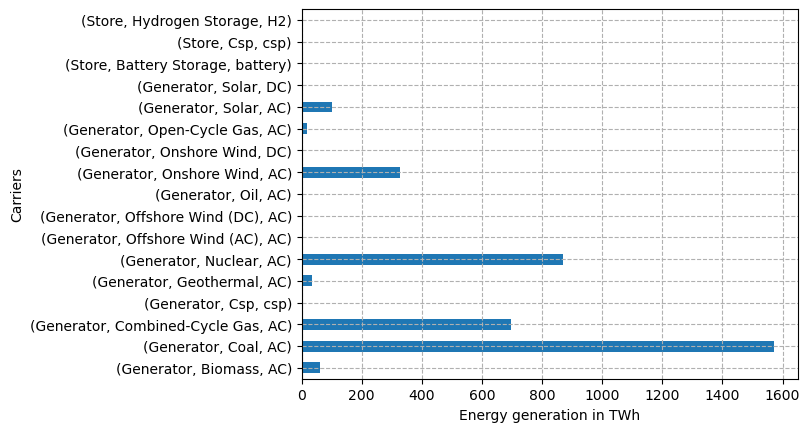

In [7]:
stats = df_n.statistics.energy_balance() / 1e6
energy_gen = stats.loc[["Generator","Store"]]
# energy_gen = energy_gen.drop(('Generator','load'))
energy_gen.plot(kind='barh')
plt.xlabel("Energy generation in TWh")
plt.ylabel("Carriers")
plt.grid(linestyle='--')

In [8]:

df_n.generators = df_n.generators.assign(p = df_n.generators_t.p.sum() * time_resolution)
df_pypsa = df_n.generators.groupby("carrier").p.sum()
# df_pypsa.loc['coal'] += df_pypsa.loc['lignite']
df_pypsa.loc['wind'] = df_pypsa.loc[["offwind-ac","offwind-dc","onwind"]].sum()
df_pypsa = df_pypsa.drop(["offwind-ac","offwind-dc","onwind"])
df_pypsa /= 1e6
df_pypsa = df_pypsa.round(2)
df_pypsa.name = 'pypsa'

In [9]:
df_eia_2020 = df_eia.iloc[6]
df_eia_2020.name = 'EIA_2020'
df_eia_2021 = df_eia.iloc[7]
df_eia_2021.name = 'EIA_2021'

# Electricity generation comparison

In [10]:
#Ignoring the rest which adds up to 2% of the total generation (4109 TWh)
pypsa_cols = ['Coal','Natural Gas','Other Gas','Nuclear','Hydro','Solar PV','PHS','Petroleum','Wind','Other Waste Biomass','Geothermal']
rename_cols = {'solar pv':'solar','other waste biomass':'biomass','hydro':'ror','natural gas':'CCGT','petroleum':'oil'}

# year 2020
df_eia_2020 = df_eia_2020[pypsa_cols]
df_eia_2020.index = df_eia_2020.index.str.lower()
df_eia_2020 = df_eia_2020.rename(index=rename_cols)

# year 2021
df_eia_2021 = df_eia_2021[pypsa_cols]
df_eia_2021.index = df_eia_2021.index.str.lower()
df_eia_2021 = df_eia_2021.rename(index=rename_cols)

df_eia_2021

coal           897.999
CCGT          1579.190
other gas       11.397
nuclear        779.645
ror            251.585
solar          112.335
phs             -5.112
oil             19.174
wind           378.197
biomass          2.267
geothermal      15.975
Name: EIA_2021, dtype: float64

In [11]:
df_compare = pd.concat([df_pypsa, df_eia_2021],axis=1)
# df_compare["error"] = df_compare.apply(lambda x: abs(x['pypsa'] - x['EIA_2021'])*100 / x['EIA_2021'],axis=1)
df_compare

,pypsa,EIA_2021
CCGT,697.28,1579.190
OCGT,18.85,NaN
biomass,59.55,2.267
coal,1571.66,897.999
csp,0.00,NaN
geothermal,34.74,15.975
nuclear,871.05,779.645
oil,0.21,19.174
solar,100.28,112.335
wind,327.23,378.197


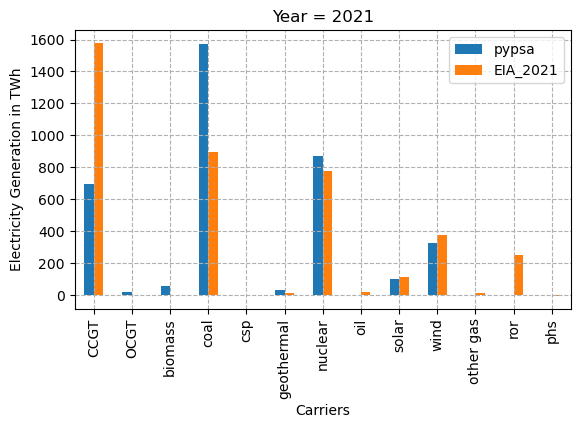

In [13]:
# Comparing the carrier mix
df_compare.plot(kind='bar')
plt.xlabel('Carriers')
plt.ylabel('Electricity Generation in TWh')
plt.grid(linestyle='--')
plt.title('Year = 2021')
plt.subplots_adjust(bottom=0.3)
plt.savefig("../plots/Electricity_gen_comparison_24H.png",dpi=800)

In [14]:
df_compare.sum()

pypsa       3680.850
EIA_2021    4042.652
dtype: float64

### Installed capacity

In [15]:
df_eia_cap = pd.read_excel("../01_Data/capacities_eia.xlsx",skiprows=1,index_col='Energy Source')
df_eia_cap

,Facility Type,Number of Generators,Generator Nameplate Capacity,Net Summer Capacity,Net Winter Capacity
Energy Source,,,,,
Coal,Utility Scale,510,205445.8,189316.3,190502.2
Petroleum,Utility Scale,3978,35526.9,30775.3,33884.8
Natural Gas,Utility Scale,6542,565950.7,502396.9,536698
Other Gases,Utility Scale,71,1891.6,1728.2,1737.6
Nuclear,Utility Scale,92,99435,94658.9,97026
Hydroelectric Conventional,Utility Scale,4005,79959.8,80067.6,79496.8
Wind,Utility Scale,1509,141951.9,141402.2,141426.4
Solar Photovoltaic,Utility Scale,5777,71699.1,71381.5,70770.3
Solar Thermal,Utility Scale,13,1497,1480.0,1352.5


In [16]:
df_eia_cap = pd.read_excel("../01_Data/capacities_eia.xlsx",skiprows=1,index_col='Energy Source')
df_eia_cap.index = df_eia_cap.index.str.lower()
df_eia_cap = df_eia_cap.rename(index={'hydroelectric conventional':'ror','hydroelectric pumped storage':'PHS','solar photovoltaic':'solar','other biomass':'biomass','natural gas':'CCGT','petroleum':'oil'})
df_eia_cap = df_eia_cap.drop(["estimated total solar","solar thermal","wood and wood-derived fuels","other energy sources","total","small scale photovoltaic","estimated total photovoltaic"])
df_eia_cap = df_eia_cap.iloc[:-1]
# # df_eia_cap.loc['solar','Generator Nameplate Capacity'] = df_eia_cap.loc['solar','Net Summer Capacity']
df_eia_cap = df_eia_cap['Generator Nameplate Capacity']
df_eia_cap.loc['ror'] += df_eia_cap.loc['PHS']
df_eia_cap = df_eia_cap.drop(["PHS"])
df_eia_cap.name = 'EIA'
df_eia_cap /= 1000
df_eia_cap

Energy Source
coal           205.4458
oil             35.5269
CCGT           565.9507
other gases      1.8916
nuclear          99.435
ror            101.9679
wind           141.9519
solar           71.6991
geothermal       3.9652
biomass          4.8994
Name: EIA, dtype: object

In [17]:
df_pypsa_cap = df_n.generators.groupby("carrier").p_nom_opt.sum()
# df_pypsa_cap.loc['coal'] += df_pypsa_cap.loc['lignite']
df_pypsa_cap.loc['wind'] = df_pypsa_cap.loc[["offwind-ac","offwind-dc","onwind"]].sum()
df_pypsa_cap = df_pypsa_cap.drop(["offwind-ac","offwind-dc","onwind"])
df_pypsa_cap /= 1000
df_pypsa_cap = df_pypsa_cap.round(2)
df_pypsa_cap.name = 'pypsa'
df_pypsa_cap

carrier
CCGT          320.68
OCGT          245.55
biomass         6.80
coal          205.45
csp             0.00
geothermal      3.97
nuclear        99.44
oil            35.42
solar          73.11
wind          141.74
Name: pypsa, dtype: float64

In [18]:
df_compare_cap = pd.concat([df_pypsa_cap,df_eia_cap],axis=1)
df_compare_cap["error"] = df_compare_cap.apply(lambda x: abs(x['pypsa'] - x['EIA'])*100 / x['EIA'],axis=1)
df_compare_cap

,pypsa,EIA,error
CCGT,320.68,565.9507,43.337821
OCGT,245.55,NaN,NaN
biomass,6.80,4.8994,38.792505
coal,205.45,205.4458,0.002044
csp,0.00,NaN,NaN
geothermal,3.97,3.9652,0.121053
nuclear,99.44,99.435,0.005028
oil,35.42,35.5269,0.300899
solar,73.11,71.6991,1.967807
wind,141.74,141.9519,0.149276


In [19]:
df_compare_cap.sum()

pypsa      1132.16
EIA      1232.7335
error    84.676434
dtype: object

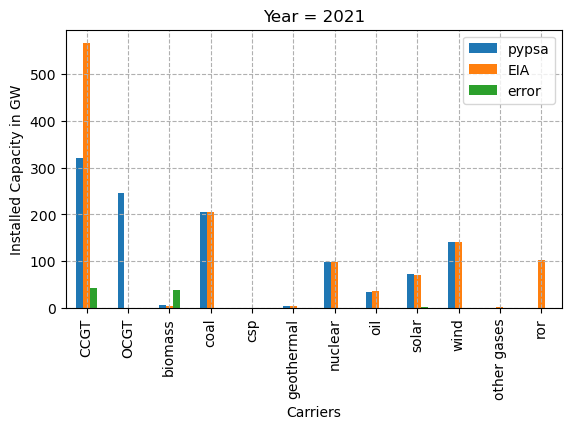

In [20]:
df_compare_cap.plot(kind='bar')
plt.xlabel('Carriers')
plt.ylabel('Installed Capacity in GW')
plt.title('Year = 2021')
plt.grid(linestyle='--')
plt.subplots_adjust(bottom=0.3)
plt.savefig("../plots/installed_cap_comparison_24H.png",dpi=800)

# Total Electricity Demand in TWh

In [21]:
df_n.loads_t.p.sum().sum() * time_resolution / 1e6

3988.186546425629

# Total Electricity Generation in TWh

In [22]:
df_n.generators_t.p.sum().sum() * time_resolution / 1e6

3680.849740372131

# Dispatch timeseries in GW

In [23]:
def plot_dispatch(n, time="2015-07"):

    # if not n.links.empty:
    #     links = (
    #         n.links_t.p1.groupby(n.links.carrier, axis=1).sum().div(1e3) * -1
    #     )
    #     links = links[conv_carriers]
    #     p_by_carrier = links
    n.carriers.loc['load','color'] = 'black'
    carrier_order = ["nuclear","CCGT","OCGT","oil","coal","solar","onwind","offwind-ac","offwind-dc","geothermal","biomass"]
    gen_car = n.generators.query('carrier != "load"').carrier.unique()
    generators = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
    p_by_carrier = generators[carrier_order]

    if not n.storage_units.empty:
        sto = (
            n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
        )
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)

    fig, ax = plt.subplots(figsize=(6, 3))

    color = p_by_carrier.columns.map(n.carriers.color)

    p_by_carrier.where(p_by_carrier > 0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )

    charge = p_by_carrier.where(p_by_carrier < 0).dropna(how="all", axis=1).loc[time]

    if not charge.empty:
        charge.plot.area(
            ax=ax,
            linewidth=0,
#             color=charge.columns.map(n.carriers.color)
        )

    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c="k",linewidth=0.1)

    plt.legend(loc=(1.05, 0),fontsize=8)
    handles = ax.legend_.legendHandles
    labels = [elt.get_text() for elt in ax.legend_.texts]
    ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1, 1.1))
    ax.set_ylabel("GW")
    ax.set_ylim(-5, 1000)
#     plt.subplots_adjust(right=0.8)
    ax.grid(linestyle="--")
    plt.savefig("../plots/dispatch_timeseries_24H.png",dpi=800)

In [24]:
df_n.generators.query('carrier != "load"').carrier.unique()

array(['CCGT', 'OCGT', 'biomass', 'coal', 'csp', 'nuclear', 'offwind-ac',
       'offwind-dc', 'oil', 'onwind', 'solar', 'geothermal'], dtype=object)

/var/folders/7q/mbr8cf915qg3d6jx6z22h5br0000gn/T/ipykernel_3255/3971166331.py:12: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/7q/mbr8cf915qg3d6jx6z22h5br0000gn/T/ipykernel_3255/3971166331.py:17: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



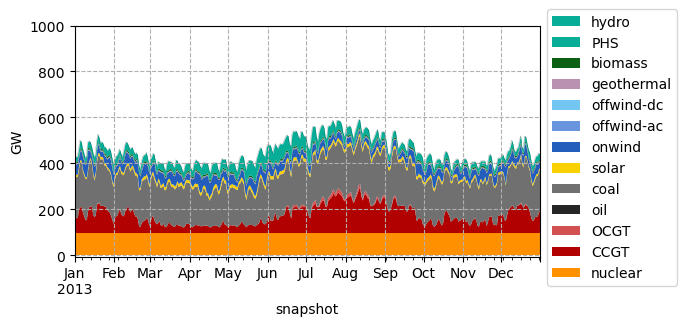

In [25]:
plot_dispatch(df_n,"2013")

In [26]:
from pypsa.plot import add_legend_patches, add_legend_circles, add_legend_lines
import cartopy.crs as ccrs
from cartopy.feature import LAND, BORDERS
import random

def plot_map(n,plot_type,key):
    carriers = n.carriers.index.tolist()[:-2]
    buses = n.buses.query('carrier == "AC" and index != "US0 7"')
    bus_index = buses.index.tolist()
    fig = plt.figure(figsize=(15,12))
    # fig = plt.figure()
    ax = plt.axes(projection=ccrs.EqualEarth())
    n.lines.loc[n.lines.bus0 == 'US0 19','s_nom'] = 0
    gen_season = []

    # n.shapes.boundary.iloc[0:1].plot(ax=ax)

    if plot_type =="capacity":
        cap = n.generators.query("carrier != 'load' and bus in @bus_index").groupby(["bus", "carrier"]).p_nom.sum()
        cap = (cap[cap.index.get_level_values('bus') != 'US0 19'])
        # sto = n.storage_units.groupby(["bus","carrier"]).p_nom.sum()
        # capacities = pd.concat([cap,sto]).reset_index().groupby(["bus","carrier"]).p_nom.sum()
        n.plot(
            ax = ax,
            bus_sizes =  cap / 2e4,
            line_widths = n.lines.s_nom / 1e4,
            line_colors = 'rosybrown',
            margin = 0.25,
            bus_alpha = 0.7,
            # bus_text = n.buses.index.tolist()
            color_geomap = True,
            link_alpha = 0

        )
        
    if plot_type in ["capacity","generation","loads"]:
        values, sizes, labels = [],[],[]
        title = ""
        if plot_type == "capacity":
            values = n.generators.query("carrier != 'load' and bus in @bus_index").groupby("bus").p_nom.sum()
            sizes = np.sort(round(values/1e3).unique()*1e3/2e4)
            labels = np.sort(round(values/1e3).unique())
            title = "Capacity (GW)"

        if plot_type == "capacity":
            x_val = 1.25
        else:
            x_val = 1.35
    if plot_type == "capacity" or plot_type == "generation":
        
        add_legend_patches(
            ax, colors=n.carriers.color.tolist()[:-2], labels=carriers, legend_kw=dict(frameon=False, bbox_to_anchor=(0, 1), title="Carriers")
        )
        
    # for bus in buses.itertuples():
    #     ax.text(bus.x, bus.y-3, bus.Index, color='black', size=8, ha='center', va='center', transform=ccrs.PlateCarree())

    ax.add_feature(LAND)
    ax.coastlines()
    # ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
    ax.add_feature(BORDERS, alpha=1, edgecolor='black')

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



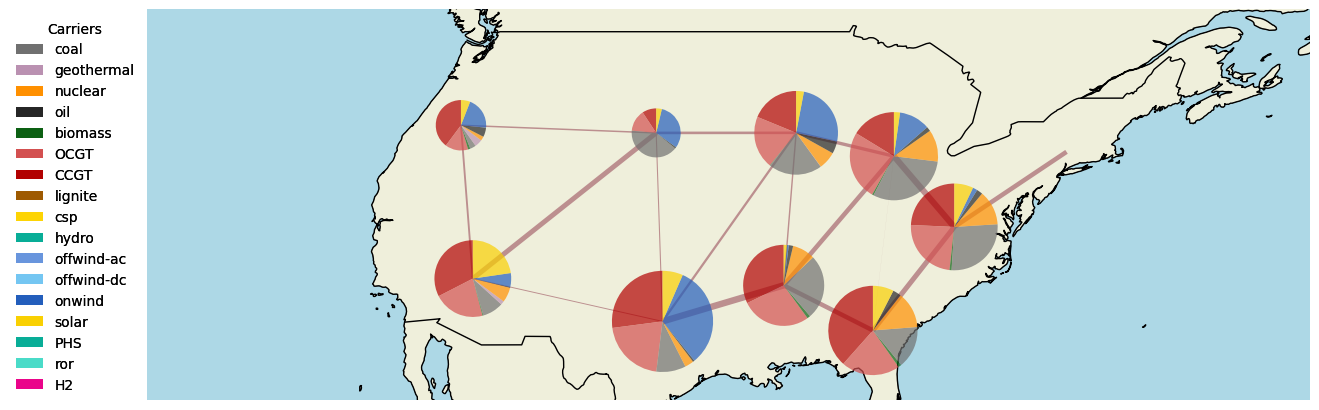

In [27]:
plot_map(df_n,"capacity","")
plt.savefig("../plots/map_capacity_24H.png",dpi=800)

# Demand timeseries in GW

<AxesSubplot:xlabel='snapshot'>

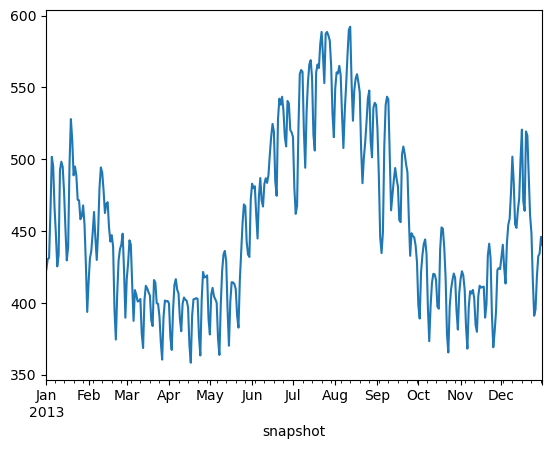

In [28]:
(df_n.loads_t.p_set.sum(axis=1) / 1e3).plot()

# Generation timeseries in GW

<AxesSubplot:xlabel='snapshot'>

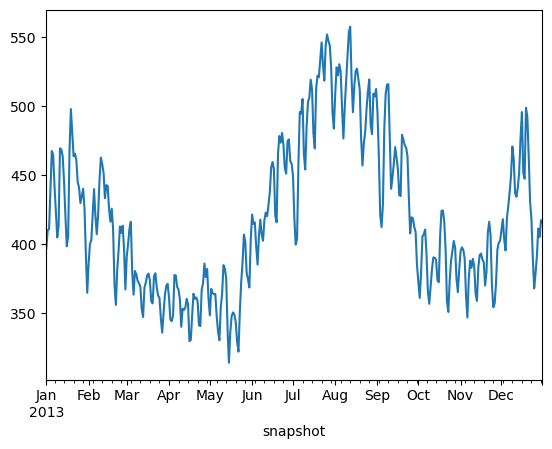

In [29]:
(df_n.generators_t.p.sum(axis=1) / 1e3).plot()

In [31]:
df_eia_monthly = pd.read_csv("../data/monthly_generation_US.csv",skiprows=4)
df_eia_monthly = df_eia_monthly.dropna(axis=0)
# df_eia_monthly = df_eia
df_eia_monthly.sort_index(ascending=False)[1:-1].reset_index()

,index,Month,all fuels (utility-scale) thousand megawatthours,coal thousand megawatthours,natural gas thousand megawatthours,nuclear thousand megawatthours,conventional hydroelectric thousand megawatthours,other renewables thousand megawatthours,hydro-electric pumped storage thousand megawatthours,other gases thousand megawatthours,petroleum liquids thousand megawatthours
0,22,Jan 2021,180728.45032,66231.49971,53913.46978,34339.450,18611.53183,6207.66901,-339.236,5.19332,1188.16274
1,21,Feb 2021,163642.61950,46241.08298,53745.50684,35324.705,18970.96776,8346.53567,-141.503,8.61941,599.04253
2,18,Mar 2021,151505.03330,40783.61682,54242.56159,30125.961,17255.70913,8281.45845,-101.948,-0.38473,611.02053
3,17,Apr 2021,170418.81556,49416.68259,57584.38116,33490.728,21177.86466,8037.76082,-322.855,-0.28468,635.12736
4,14,May 2021,207175.70902,66423.90191,74851.67559,36854.337,21826.51122,6434.49710,-269.964,-0.27507,671.97540
5,13,Jun 2021,226361.26789,76451.54978,84946.61256,38370.528,20109.28476,5808.25001,-550.845,-0.26008,652.04572
6,10,Jul 2021,227826.91444,77465.31171,85233.24209,38751.840,18598.49465,6727.14729,-531.015,-0.27507,935.49064
7,9,Aug 2021,185991.21152,60310.64295,66831.68497,35305.664,15288.52205,7301.00061,-313.409,0.00000,740.36142
8,8,Sep 2021,166407.27799,45722.47543,62206.18236,34522.285,15382.67232,7659.95553,-333.460,0.00000,690.40235
9,5,Oct 2021,162701.85066,41645.58231,58942.31276,34882.319,17372.67955,8852.16839,-301.523,0.00000,647.13462


In [32]:
df_pypsa_grouped = df_n.generators_t.p.groupby(df_n.generators.carrier,axis=1).sum() * 24
df_pypsa_monthly = df_pypsa_grouped.groupby(df_pypsa_grouped.index.month).sum()
df_pypsa_monthly = df_pypsa_monthly.sum(axis=1).div(1e6)
df_pypsa_monthly.name = 'PyPSA'
df_pypsa_monthly.index = np.arange(0,12)
df_pypsa_monthly

/var/folders/7q/mbr8cf915qg3d6jx6z22h5br0000gn/T/ipykernel_3255/3800570336.py:1: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



0     325.319970
1     278.790654
2     276.059636
3     257.824601
4     267.748454
5     315.493812
6     369.649156
7     378.818499
8     325.832600
9     287.320916
10    276.130258
11    321.861185
Name: PyPSA, dtype: float64

In [44]:
df_eia = pd.read_excel("../data/Table_7.2a_Electricity_Net_Generation__Total_(All_Sectors).xlsx",skiprows=10)
df_eia_monthly_2021 = df_eia.loc[df_eia.Month.dt.year == 2021].reset_index()
df_eia_monthly_2021 = df_eia_monthly_2021["Electricity Net Generation Total (including from sources not shown), All Sectors"]
df_eia_monthly_2021 = df_eia_monthly_2021 / 1000
# df_eia_monthly_2021 = df_eia_monthly_2021.reset_index()
df_eia_monthly_2021.name = 'EIA'
df_eia_monthly_2021

0     349.209709
1     323.899529
2     311.397276
3     293.307944
4     320.180962
5     373.856478
6     405.624091
7     412.864768
8     347.743775
9     320.201778
10    314.309521
11    337.103561
Name: EIA, dtype: object

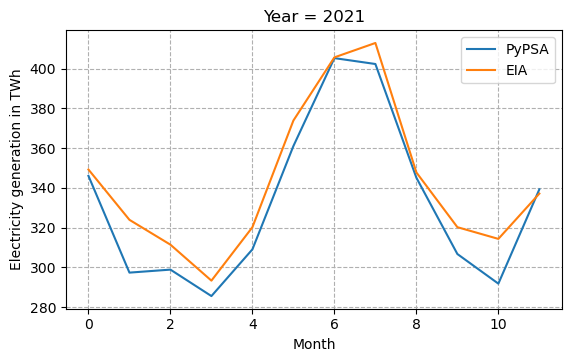

In [45]:
df_compare_gen_ts = pd.concat([df_pypsa_monthly,df_eia_monthly_2021],axis=1)
df_compare_gen_ts.plot()
plt.xlabel('Month')
plt.ylabel('Electricity generation in TWh')
plt.title('Year = 2021')
plt.grid(linestyle='--')
plt.subplots_adjust(bottom=0.3)
plt.savefig("../plots/electricity_gen_ts.png",dpi=800)

In [46]:
df_eia = pd.read_excel("../data/Table_7.6_Electricity_End_Use_and_Electric_Vehicle_Use.xlsx",skiprows=10)
df_eia_monthly_2021 = df_eia.loc[df_eia.Month.dt.year == 2021].reset_index()
df_eia_monthly_2021 = df_eia_monthly_2021["Electricity End Use, Total"]
# df_eia_monthly_2021 = df_eia_monthly_2021["Electricity Sales to Ultimate Customers, Total"]
df_eia_monthly_2021 = df_eia_monthly_2021 / 1000
# # df_eia_monthly_2021 = df_eia_monthly_2021.reset_index()
df_eia_monthly_2021.name = 'EIA'
df_eia_monthly_2021

0      333.97653
1     309.816283
2     306.272657
3      283.32879
4     301.122292
5     350.199269
6     386.625923
7     393.627941
8     347.832293
9     313.613342
10    298.838866
11    319.535135
Name: EIA, dtype: object

In [47]:
df_eia = pd.read_excel("../data/Table_7.6_Electricity_End_Use_and_Electric_Vehicle_Use.xlsx",skiprows=10)
df_eia_monthly_2020 = df_eia.loc[df_eia.Month.dt.year == 2020].reset_index()
df_eia_monthly_2020 = df_eia_monthly_2020["Electricity End Use, Total"]
df_eia_monthly_2020 = df_eia_monthly_2020 / 1000
# # df_eia_monthly_2021 = df_eia_monthly_2021.reset_index()
df_eia_monthly_2020.name = 'EIA 2020'
df_eia_monthly_2020

0     328.246135
1     306.425243
2       301.7527
3     273.132424
4     285.627076
5     331.355301
6     391.577954
7     380.979969
8     333.682753
9     307.869372
10    288.228154
11    327.499941
Name: EIA 2020, dtype: object

In [48]:
df_pypsa_grouped = df_n.loads_t.p.sum(axis=1) * time_resolution
df_pypsa_monthly = df_pypsa_grouped.groupby(df_pypsa_grouped.index.month).sum()
df_pypsa_monthly = df_pypsa_monthly.div(1e6)
df_pypsa_monthly.name = 'PyPSA'
df_pypsa_monthly.index = np.arange(0,12)
df_pypsa_monthly

0     346.021667
1     297.342062
2     298.848573
3     285.545290
4     309.043998
5     361.021042
6     405.248279
7     402.285108
8     345.081304
9     306.702148
10    291.793785
11    339.253291
Name: PyPSA, dtype: float64

In [49]:
# df_bev = pd.read_csv("../data/demand_BEV.csv")
df_bev = pd.read_csv("../data/demand_basegrid.csv")
df_bev = df_bev.set_index("UTC Time")
df_bev_monthly = df_bev.groupby(pd.to_datetime(df_bev.index).month).sum()
# df_bev_monthly = df_bev_monthly.sum() 
df_bev_monthly = df_bev_monthly.sum(axis=1)
df_bev_monthly = df_bev_monthly / 1e6
df_bev_monthly.name = 'BEV'
df_bev_monthly.index = np.arange(0,12)
df_bev_monthly


0     346.611661
1     307.499217
2     299.358134
3     286.032168
4     309.570943
5     361.636612
6     405.939259
7     402.971036
8     345.669695
9     307.225100
10    292.291317
11    339.831745
Name: BEV, dtype: float64

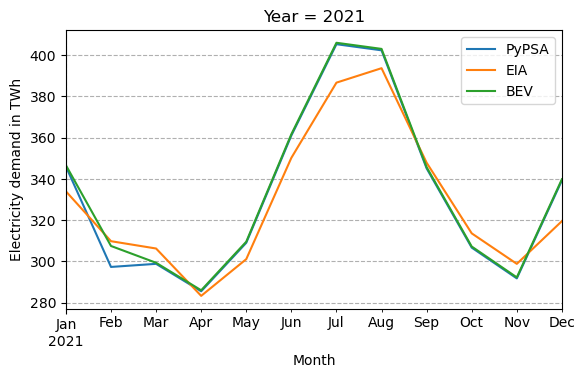

In [50]:
df_compare_dem_ts = pd.concat([df_pypsa_monthly,df_eia_monthly_2021,df_bev_monthly],axis=1)
df_compare_dem_ts.index = df_eia.loc[df_eia.Month.dt.year == 2021].Month.tolist()
df_compare_dem_ts.plot()
plt.xlabel('Month')
plt.ylabel('Electricity demand in TWh')
plt.title('Year = 2021')
plt.grid(linestyle='--')
plt.subplots_adjust(bottom=0.3)
plt.savefig("../plots/electricity_demand_ts.png",dpi=800)

# CO2 emissions in Mtonnes

In [53]:
e = (
    df_n.generators_t.p
    / df_n.generators.efficiency
    * df_n.generators.carrier.map(df_n.carriers.co2_emissions)
)
emissions = df_n.snapshot_weightings.generators @ e.sum(axis=1).div(1e6)

In [54]:
emissions

1472.7999884748203